The RT60 is 83 ms
(2, 316761)
(257, 1237, 2)


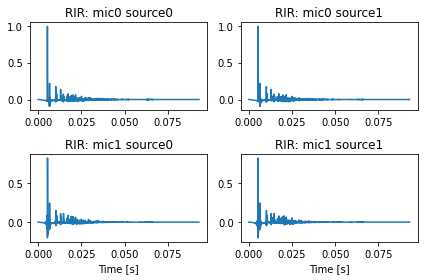

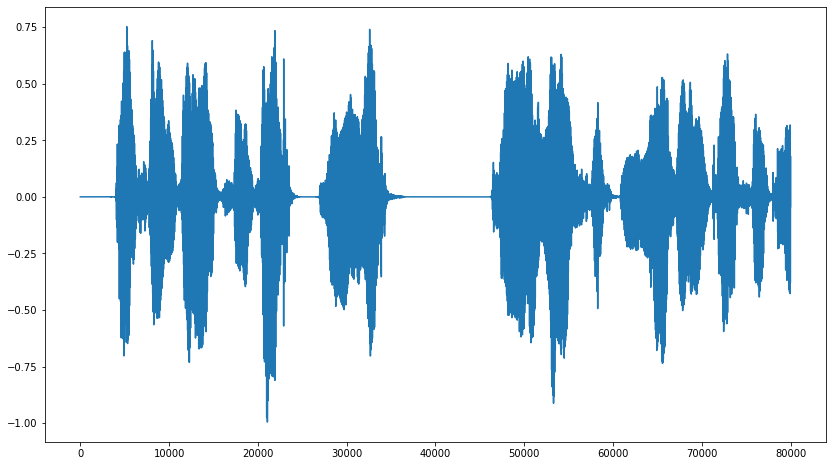

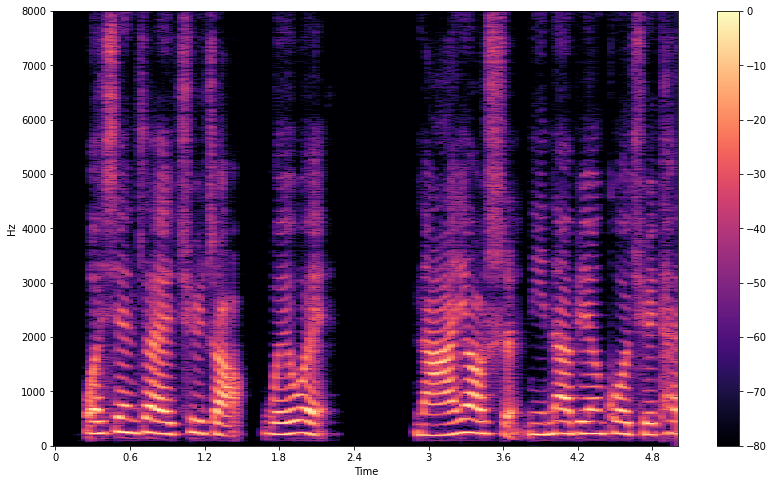

In [108]:
import numpy as np
import librosa
from scipy.fftpack import fft
import matplotlib.pyplot as plt
from tqdm import tqdm
from DistantSpeech.transform.transform import Transform
from DistantSpeech.beamformer.utils import pmesh, mesh, load_wav, save_audio, load_pcm, visual, pt
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.beamformer.MicArray import MicArray, ArraySim
from DistantSpeech.beamformer.beamformer import beamformer
from DistantSpeech.beamformer.MicArray import MicArray, compute_tau
from DistantSpeech.noise_estimation.mcspp import McSpp
from DistantSpeech.adaptivefilter.FastFreqLms import FastFreqLms
wavpath = '/home/wangwei/work/Beamforming-for-speech-enhancement-master/sample_data'
array_data, _ = load_wav(wavpath)

mic_angle_vector = [0,60,120,180,240,300]
sampling_frequency = 16000
fft_length = 512
fft_shift = 256
mic_diameter = 0.064
sound_speed = 343
look_direction = 30

# signal = audioread("/home/wangwei/work/DistantSpeech/samples/kws_samples/xiaolan_long.wav")
signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/5_541_20170608093550_4.wav")
noise = audioread("/home/wangwei/work/DistantSpeech/samples/noise/office1.wav")
fs = 16000
M = 2
mic_array = MicArray(arrayType="linear", r=mic_diameter/2, M=M, n_fft=fft_length)
mic_array_sim = mic_array.array_sim
# print(mic_array_sim.R)
array_data, premix = mic_array_sim.generate_audio(signal, interference=noise, source_angle=look_direction, interf_angle=30, sir=0, snr=30, source_distance=1.0, interf_distance=1.0)
audiowrite('mix_kws.wav', np.transpose(array_data))
# audiowrite('signal.wav', np.transpose(premix[0, :, :]))
# audiowrite('interf.wav', np.transpose(premix[1, :, :]))
print(array_data.shape)
M = array_data.shape[0]
transform = Transform(n_fft=512, hop_length=256, channel=M)
D = transform.stft(np.transpose(array_data))
half_bin = D.shape[0]
frame_num = D.shape[1]
print(D.shape)

x1 = premix[1, 0,10000:80000]
x2 = premix[1, 1,10000:80000]

x1 = premix[0, 0,100000:180000]
x2 = premix[0, 1,100000:180000]
pt(x1)
visual(x1)

h1 = mic_array_sim.room.rir[0][0]
h2 = mic_array_sim.room.rir[1][0]

# pt(premix[0, 0,:])

## Demo for non-causal system identification

100%|██████████| 77952/77952 [00:00<00:00, 434421.60it/s]


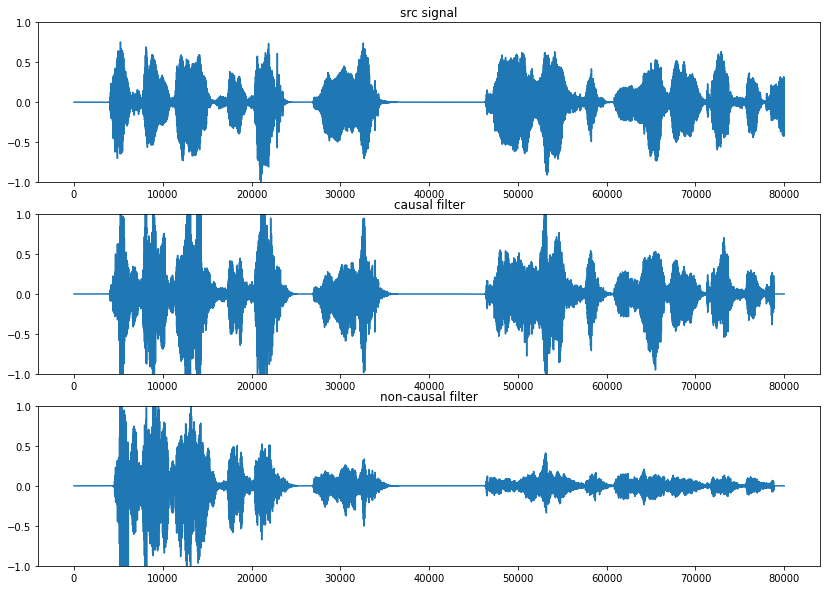

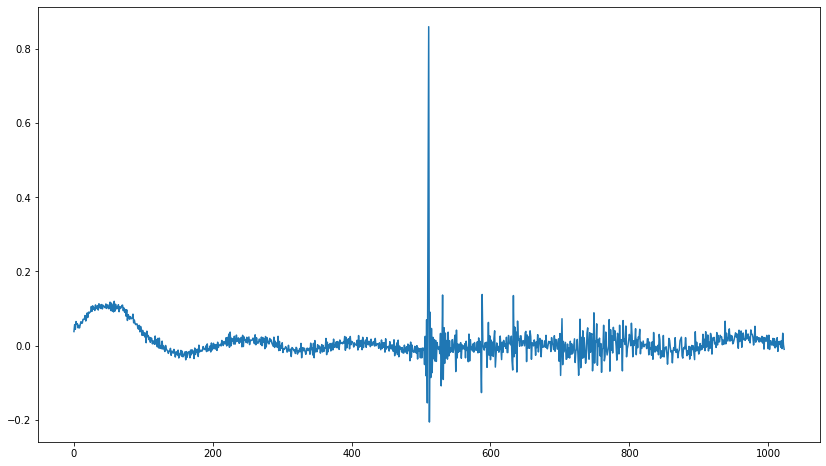

In [109]:
filter_len = 1024
frameLen = filter_len
hop = int(frameLen / 2)

flms = FastFreqLms(filter_len=filter_len, mu=0.1)
flms_noncausal = FastFreqLms(filter_len=filter_len, mu=0.1, non_causal=True)

# x2 = x2[hop:]
valid_len = len(x1)-flms.filter_len*2  # discard last frame

est_err_flms = np.zeros(valid_len)
est_err_flms_n = np.zeros(valid_len)
est_err_flms = np.zeros(valid_len)

output = np.zeros(x1.shape)
output_n = np.zeros(x1.shape)


for n in tqdm(range((valid_len))):
    if np.mod(n, flms.filter_len) == 0:
        input_vector = x2[n: n +  flms.filter_len]
        d_vector = x1[n : n + flms.filter_len]

        err, w_flms = flms.update(input_vector, d_vector)
        err_n, w_flms_n = flms_noncausal.update(input_vector, d_vector)

        output[n : n + flms.filter_len] = err[:, 0]
        output_n[n : n + flms.filter_len] = err_n[:, 0]

fig, axs = plt.subplots(3, figsize=(14, 10))
axs[0].plot(x1)
axs[0].set_title('src signal')
axs[0].set_ylim([-1.0,1.0])
axs[1].plot(output)
axs[1].set_title('causal filter')
axs[1].set_ylim([-1.0,1.0])
axs[2].plot(output_n)
axs[2].set_title('non-causal filter')
axs[2].set_ylim([-1.0,1.0])

pt(w_flms_n)



## Demo for FIR constraint

100%|██████████| 77952/77952 [00:00<00:00, 411543.95it/s]


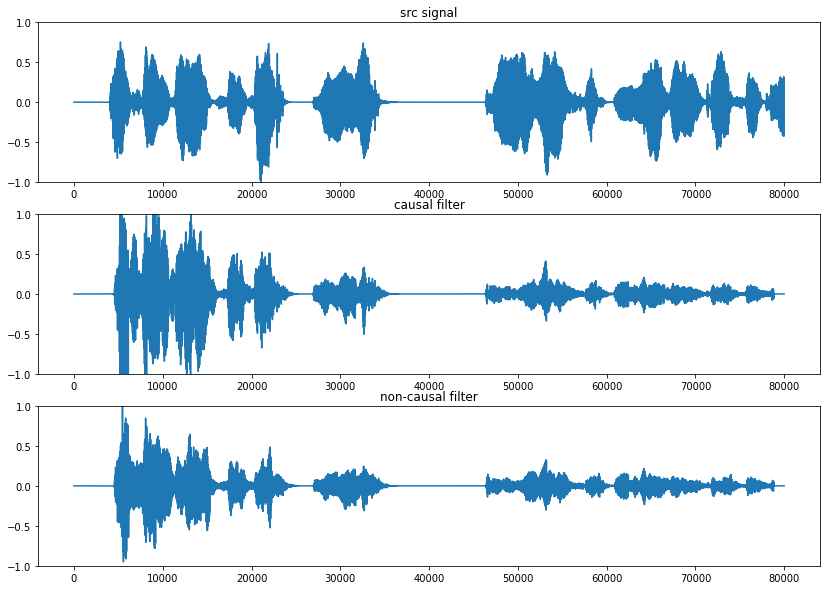

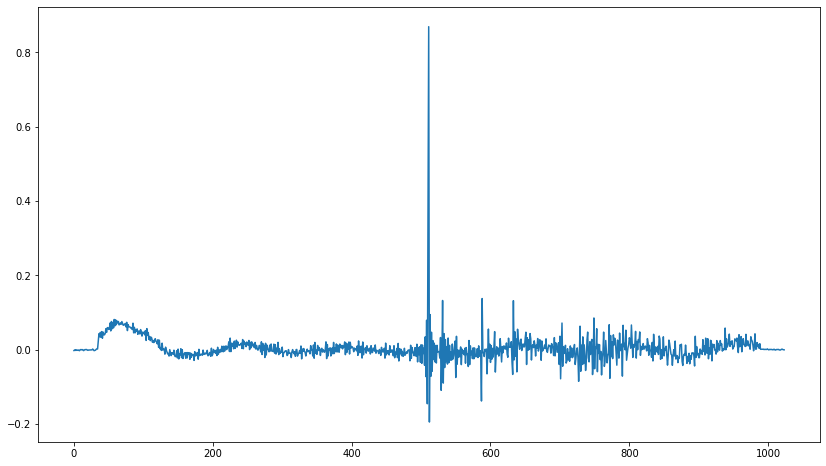

In [110]:
filter_len = 1024
frameLen = filter_len
hop = int(frameLen / 2)

flms_noncausal = FastFreqLms(filter_len=filter_len, mu=0.1, non_causal=True)
flms_noncausal_fir = FastFreqLms(filter_len=filter_len, mu=0.1, non_causal=True)

# x2 = x2[hop:]
valid_len = len(x1)-flms.filter_len*2  # discard last frame

est_err_flms = np.zeros(valid_len)
est_err_flms_n = np.zeros(valid_len)
est_err_flms = np.zeros(valid_len)

output = np.zeros(x1.shape)
output_n = np.zeros(x1.shape)


for n in tqdm(range((valid_len))):
    if np.mod(n, flms.filter_len) == 0:
        input_vector = x2[n: n +  flms_noncausal_fir.filter_len]
        d_vector = x1[n : n + flms_noncausal_fir.filter_len]

        err, w_flms = flms_noncausal.update(input_vector, d_vector)
        err_n, w_flms_n = flms_noncausal_fir.update(input_vector, d_vector, fir_constraint=True, fir_truncate=35)

        output[n : n + flms_noncausal.filter_len] = err[:, 0]
        output_n[n : n + flms_noncausal_fir.filter_len] = err_n[:, 0]

fig, axs = plt.subplots(3, figsize=(14, 10))
axs[0].plot(x1)
axs[0].set_title('src signal')
axs[0].set_ylim([-1.0,1.0])
axs[1].plot(output)
axs[1].set_title('causal filter')
axs[1].set_ylim([-1.0,1.0])
axs[2].plot(output_n)
axs[2].set_title('non-causal filter')
axs[2].set_ylim([-1.0,1.0])

pt(w_flms_n)

